# Install requirements

Eventually these requirements should make it into a `requirements.txt` or `env.yaml`, but for the moment installing as part of the notebook.

In [2]:
!pip install mnist

In [3]:
!pip install onnxruntime

     |████████████████████████████████| 3.1MB 886kB/s eta 0:00:01


In [4]:
!pip install onnx

     |████████████████████████████████| 7.1MB 693kB/s eta 0:00:01


In [25]:
!pip install pillow

# Load MNIST dataset

Here the "test" subset of the handwritten-digit recognition dataset, but to use the training (bigger) subset, the method only requires using `train_images` rather than `test_images` below.

In [5]:
import mnist

In [6]:
mnist.temporary_dir = lambda : '/data/mnist-data'

In [8]:
test_images = mnist.test_images().tolist()

In [9]:
assert(len(test_images) == 10000)

In [10]:
import os, sys

In [11]:
os.listdir('/data/mnist-data')

['t10k-images-idx3-ubyte.gz']

In [12]:
%matplotlib inline

In [26]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

The `mnist` module parses the original dataset, each image encoded as a list with 28 elements, each a list of 28 integers in the range 0-255:

In [15]:
type(test_images[0])

list

In [16]:
type(test_images[0][0])

list

In [17]:
len(test_images[0])

28

In [18]:
len(test_images[0][0])

28

This encoding can be read as `numpy` arrays as follows:

In [21]:
test_mat = np.array(test_images[0])

In [22]:
test_mat.shape

(28, 28)

Note that by default the array is read as `int64`:

In [24]:
test_mat.dtype

dtype('int64')

We can use this form to verify that the images are being adequately read:

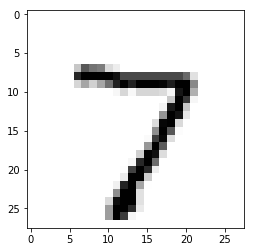

In [26]:
plt.imshow(test_mat, cmap='Greys')

Below there's a convenience function to display any image in the dataset by providing the index (for the "test" dataset, this should be a number between 0 and 9999):

In [10]:
def display_nth_image(i):
    plt.imshow(np.array(test_images[i]), cmap='Greys')

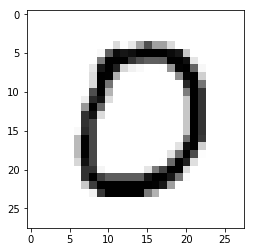

In [11]:
display_nth_image(10)

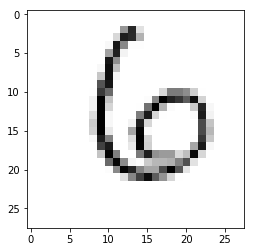

In [12]:
display_nth_image(100)

Note that using a different colormap radically changes the way the image is displayed, so be mindful of what value you use for that argument.

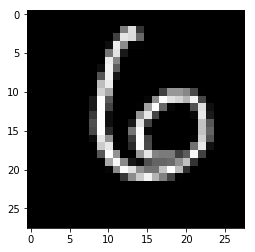

In [14]:
plt.imshow(np.array(test_images[100]), plt.get_cmap('gray'))

A quick look at the *contents* of the arrays, as the samples are read reveals that the images are in the range of 0-255, so they can be encoded as `uint8`:

In [14]:
arr = np.array(test_images[0])

In [15]:
arr.shape

(28, 28)

In [17]:
arr1 = arr.reshape(1,28*28)

In [19]:
lst = arr.reshape(28*28).tolist()

In [24]:
','.join(str(i) for i in set(lst))

'0,129,1,3,133,5,9,140,14,17,18,19,21,22,151,159,31,163,36,35,166,38,40,170,44,52,182,185,58,59,60,187,62,57,61,66,67,198,72,75,203,205,77,207,209,83,84,219,221,222,224,225,121,227,126,229,233,106,236,238,240,241,114,115,242,248,249,250,251,253,254,255'

# Serializing samples as images

Manipulating samples as image files provides a more general dataset-management experience that avoids the MNIST-specific vagaries (note that it does this at the expense of possibly higher memory/disk usage).  

After some experimentation, the `PIL` (or `pillow` for Python 3+) library was found the most effective to do this.  Below, the `Image` type comes from this library (the later use of `IPython.display` is an artifact of these experimentation having been carried out within a Jupyter notebook.

In [34]:
img = Image.fromarray(arr.astype('uint8'))

In [35]:
img.save("test.png")

In [36]:
imgfrom = Image.open("test.png")

In [37]:
arrfrom = np.array(imgfrom)

In [38]:
arrfrom.shape

(28, 28)

In [39]:
arrfrom.dtype

dtype('uint8')

In [40]:
arrcheck = np.array(test_images[0]).astype('uint8')

In [42]:
np.all(arrcheck == arrfrom)

True

In [43]:
from IPython.display import display

In [44]:
display(imgfrom)

In [49]:
img2 = Image.fromarray(np.array(test_images[19]).astype('uint8'))

In [50]:
display(img2)

# Inference

With the details of the dataset out of the way, we can now verify that the inference engine is working properly.  We do this by pulling the MNIST onnx model and the (very small) "confirmation" samples packed with it.

In [53]:
import onnxruntime as ort

In [54]:
sess = ort.InferenceSession('/data/mnist/model.onnx', None)

In [55]:
in_name = sess.get_inputs()[0].name

In [56]:
out_name = sess.get_outputs()[0].name

In [28]:
# read in test data protobuf files included with the model
import onnx
from onnx import numpy_helper

In [36]:
tdata_idx = 1

In [37]:
tensor = onnx.TensorProto()
with open(os.path.join(f'/data/mnist/test_data_set_{tdata_idx}/input_0.pb'), 'rb') as f:
    tensor.ParseFromString(f.read())
input_data = numpy_helper.to_array(tensor)

In [38]:
input_data.shape

(1, 1, 28, 28)

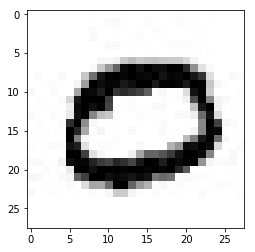

In [39]:
plt.imshow(input_data[0,0,:,:], cmap = plt.cm.Greys)

In [57]:
input_data.dtype

dtype('float32')

In [61]:
r = sess.run([out_name], {in_name : input_data})

In [66]:
int(np.argmax(np.array(r[0]).squeeze(), axis=0))

0

# Inference on a png's content

Now, let's try the same for the array we read from the sample we dumped to png earlier:

In [59]:
arr = np.array(img2).astype('float32').reshape(1,1,28,28)

In [60]:
r = sess.run([out_name], {in_name : arr})

In [61]:
int(np.argmax(np.array(r[0]).squeeze(), axis=0))

4